In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
import quantstats as qs

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from Trader import TradingEngine

# Download data

In [213]:
start = '2000-01-01'
end = '2025-08-01'

In [277]:
# Asset 1 data
asset_1 = yf.download('HO=F', start=start, end=end, interval='1d')
asset_1.columns = [f"{price}" for price, _ in asset_1.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_32060\979573987.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_1 = yf.download('HO=F', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [279]:
# Asset 2 data
asset_2 = yf.download('RB=F', start=start, end=end, interval='1d')
asset_2.columns = [f"{price}" for price, _ in asset_2.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_32060\2664427952.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_2 = yf.download('RB=F', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [281]:
df = pd.DataFrame({
    'asset_1': asset_1['Close'],
    'asset_2': asset_2['Close']
}).dropna()


In [283]:
date_split = '2020-07-31'
index_split = df.index.get_loc(date_split)

df_train will be used to perform our statistical tests on and calculate our hedge ratio. It will represent our known historical data

In [286]:
df_train = df.loc[df.index<=date_split].copy()

# Statistical tests

First we must test for cointegration of the two time series. A p-value < 0.05 below means we can reject the null hypothesis of no cointegration.

In [290]:
score, pvalue, _ = ts.coint(df_train.asset_1, df_train.asset_2)

print(f"Cointegration Test Score: {score}")
print(f"P-value: {pvalue}")


Cointegration Test Score: -6.153673915633721
P-value: 7.512150987216368e-07


Now lets use fit a regression model to determine the hedge ratio

In [293]:
X = ts.add_constant(df_train.asset_2)  # Independent variable (e.g., HO)
model = ts.OLS(df_train.asset_1, X).fit()
hedge_ratio = model.params.iloc[1]

print(f"Hedge Ratio (asset 1 vs asset 2): {hedge_ratio}")

Hedge Ratio (asset 1 vs asset 2): 1.0550348699132783


In [295]:
df['spread'] = df.asset_1 - hedge_ratio * df.asset_2
df_train['spread'] = df_train.asset_1 - hedge_ratio * df_train.asset_2

Now lets test to ensure the stationarity of our spread

In [298]:
print(ts.adfuller(df_train.spread)[1] < 0.05)

True


Pairs used so far that have passed the statistical tests:    
BZ + RB  
HO + RB  

# Some plots

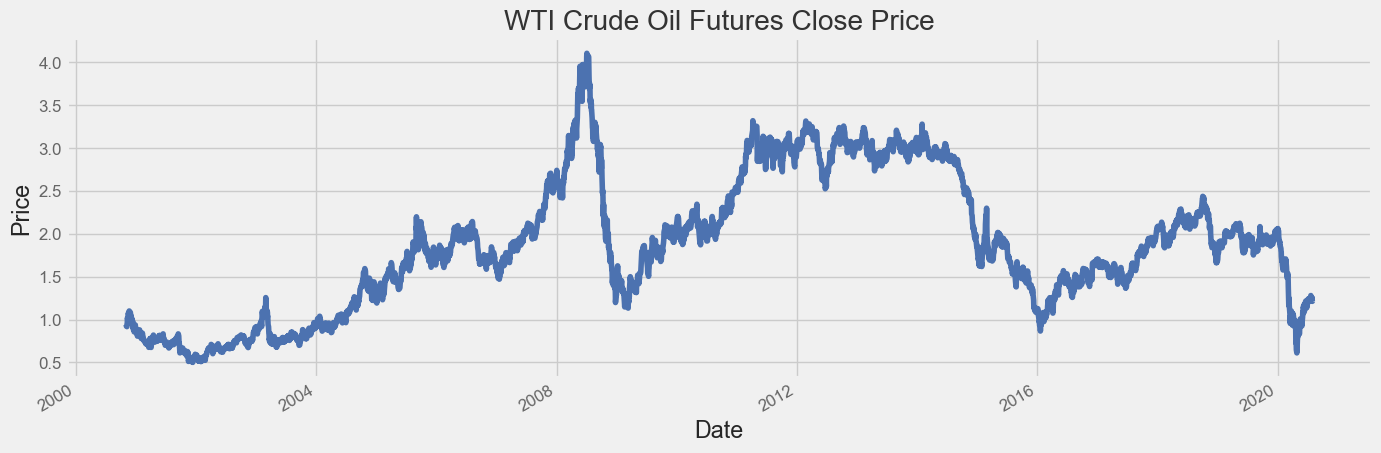

In [302]:
df_train.asset_1.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='WTI Crude Oil Futures Close Price', 
              ylabel='Price')
plt.show()

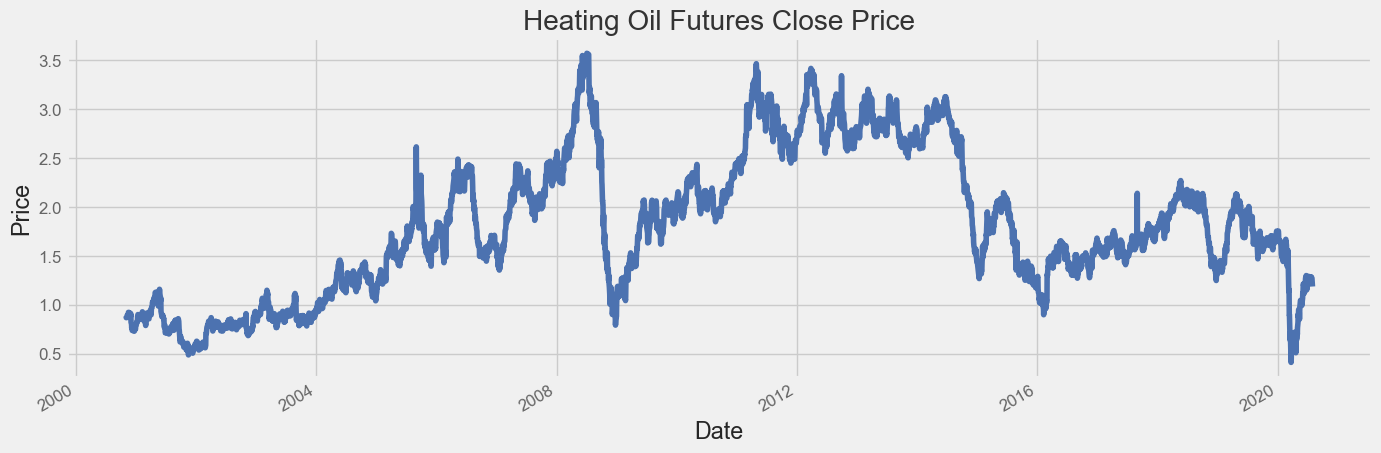

In [303]:
df_train.asset_2.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Heating Oil Futures Close Price', 
              ylabel='Price')
plt.show()

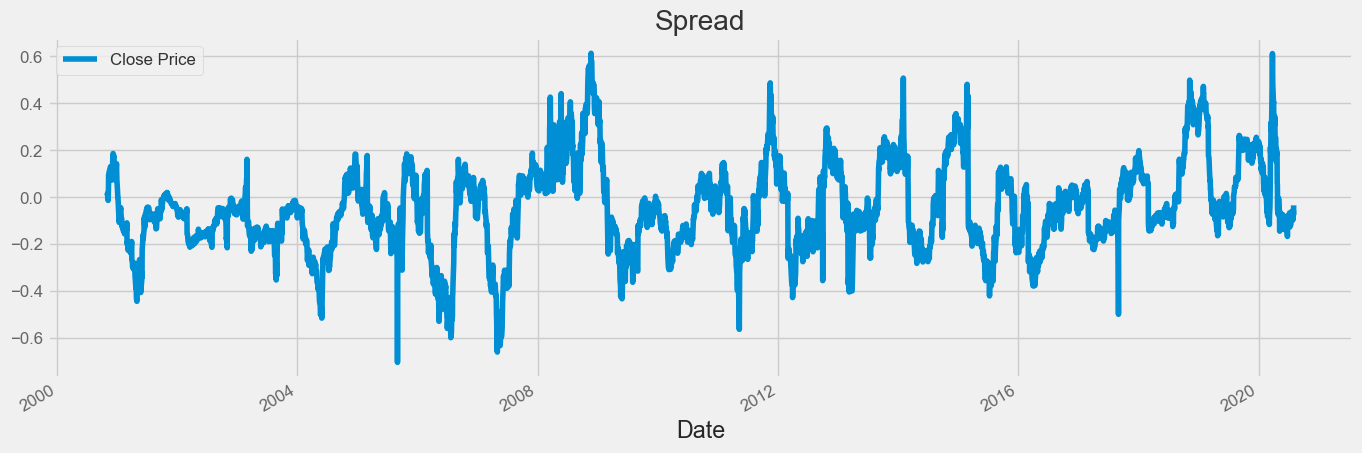

In [305]:
fig, ax = plt.subplots(figsize=(15,5))
df_train.spread.plot(ax=ax, label='Close Price', title='Spread')
ax.legend()
plt.show()

# Implement strategy on training data

In [311]:
# Construct upper and lower bounds based off the spreads trend and volatility
n_stds = 1.5
rolling_window = 252    #Approximately one-year of trading days
df['spread_ma'] = df.spread.rolling(window=rolling_window).mean()
df['spread_ub'] = df.spread_ma + df.spread.rolling(window=rolling_window).std() * n_stds
df['spread_lb'] = df.spread_ma - df.spread.rolling(window=rolling_window).std() * n_stds

# Determine the maximum signal over the training period to scale signal strength
df_train = df.loc[df.index<=date_split].copy()
max_signal = max(np.max(df_train.spread - df_train.spread_ub), np.max(df_train.spread_lb - df_train.spread))

# Construct buy and sell signals
df['buy_signal'] = (df.spread_lb - df.spread).apply(lambda x: x/max_signal if x > 0 else 0)
df['sell_signal'] = (df.spread - df.spread_ub).apply(lambda x: -x/max_signal if x > 0 else 0)

In [313]:
df_train = df.loc[df.index<=date_split].copy()
df_test = df.loc[df.index>=date_split].copy()

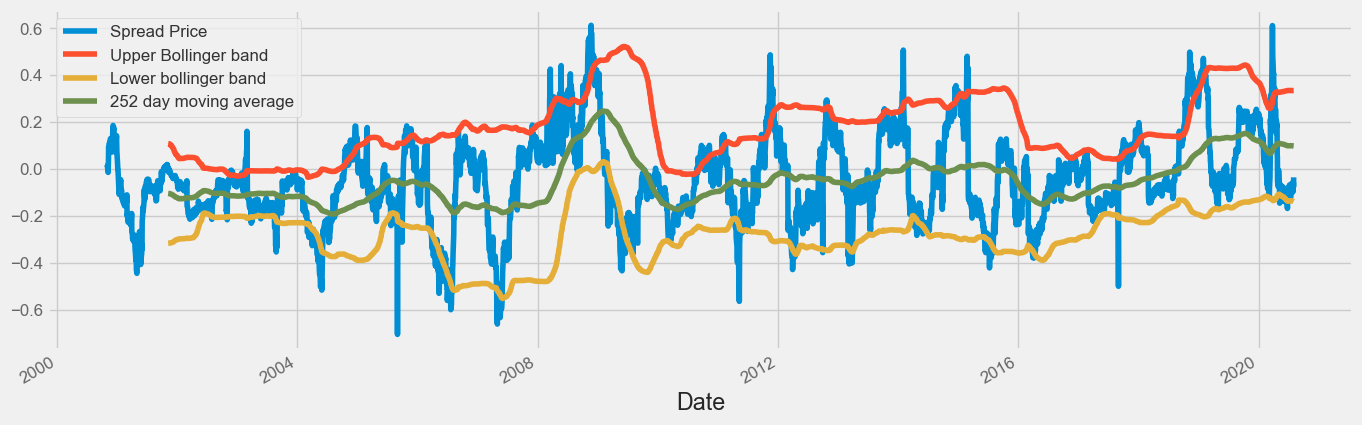

In [315]:
fig, ax = plt.subplots(figsize=(15,5))
df_train.spread.plot(ax=ax, label='Spread Price')
df_train.spread_ub.plot(ax=ax, label='Upper Bollinger band')
df_train.spread_lb.plot(ax=ax, label='Lower bollinger band')
df_train.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

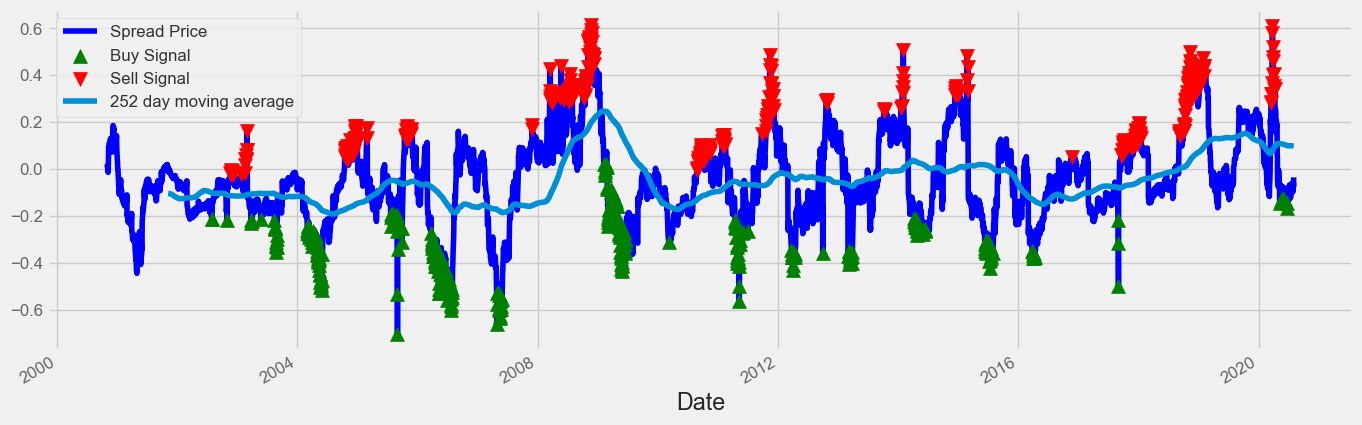

In [316]:
buy_mask = df_train.buy_signal > 0
sell_mask = df_train.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_train.index, df_train['spread'], label='Spread Price', color='blue')
ax.scatter(df_train.index[buy_mask], df_train['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df_train.index[sell_mask], df_train['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df_train.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [319]:
train_trader = TradingEngine(balance=1000)

In [321]:
train_returns = train_trader.run_strategy(np.array(df_train.buy_signal), np.array(df_train.sell_signal), np.array(df_train.spread), 
                    np.array(df_train.spread_ma), df_train.index, allow_negative_balance=False, risk_factor=0.01)

# Performance evaluation

In [324]:
print(f'Final balance: {train_trader.balance:.2f}')
print(f'Net position: {train_trader.position}')
print(f'Number of trades: {train_trader.trade_count}')

Final balance: 2841.85
Net position: 0
Number of trades: 823


                           Strategy
-------------------------  ----------
Start Period               2000-11-01
End Period                 2020-07-31
Risk-Free Rate             0.0%
Time in Market             48.0%

Cumulative Return          184.18%
CAGR﹪                     3.72%

Sharpe                     0.47
Prob. Sharpe Ratio         99.32%
Smart Sharpe               0.46
Sortino                    0.96
Smart Sortino              0.92
Sortino/√2                 0.68
Smart Sortino/√2           0.65
Omega                      1.29

Max Drawdown               -29.94%
Max DD Date                2009-05-27
Max DD Period Start        2009-02-24
Max DD Period End          2009-09-09
Longest DD Days            198
Volatility (ann.)          12.85%
Calmar                     0.12
Skew                       11.11
Kurtosis                   265.24

Expected Daily %           0.02%
Expected Monthly %         0.44%
Expected Yearly %          5.1%
Kelly Criterion            11.68%
Risk of Rui

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-02-24,2009-05-27,2009-09-09,198,-29.939698,-28.102717
2,2010-12-01,2011-02-04,2011-02-28,90,-17.175377,-16.950732
3,2003-02-06,2003-02-28,2003-02-28,23,-10.168413,-5.919416
4,2010-10-12,2010-11-09,2010-11-16,36,-8.054995,-7.882153
5,2005-02-02,2005-02-28,2005-03-02,29,-8.009589,-6.510869


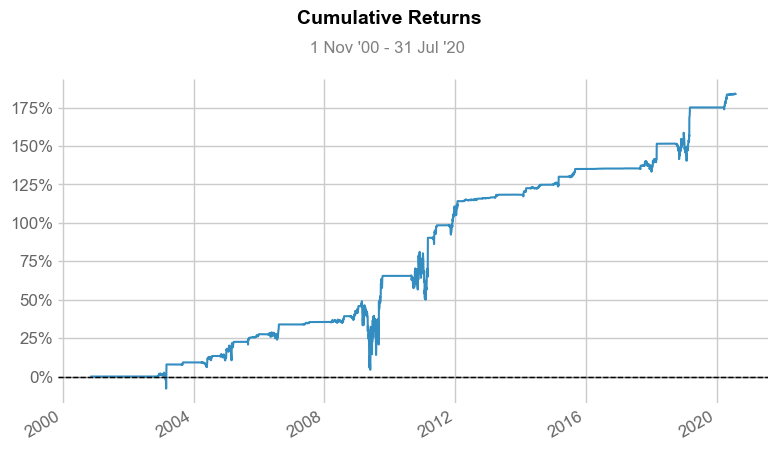

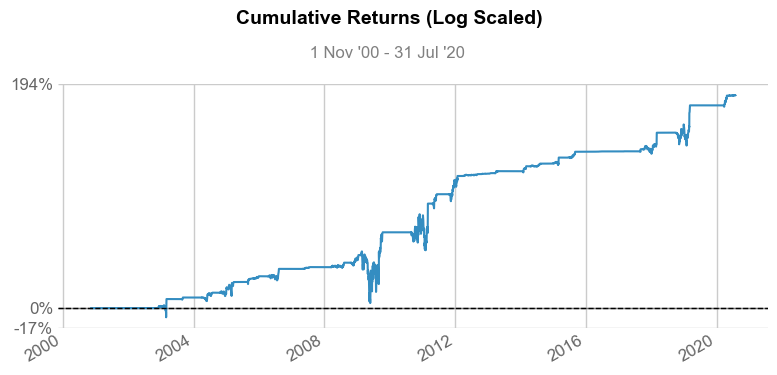

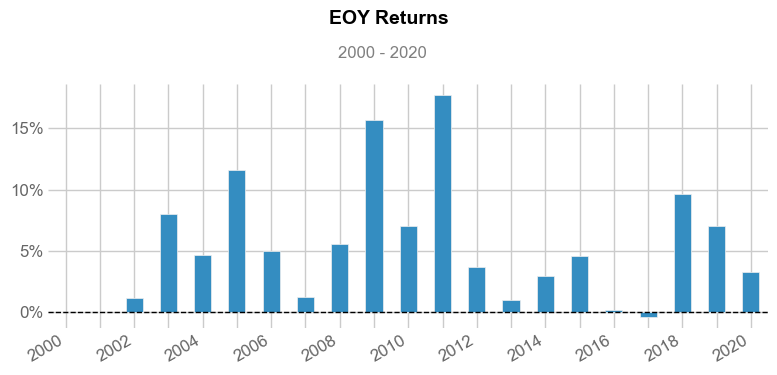

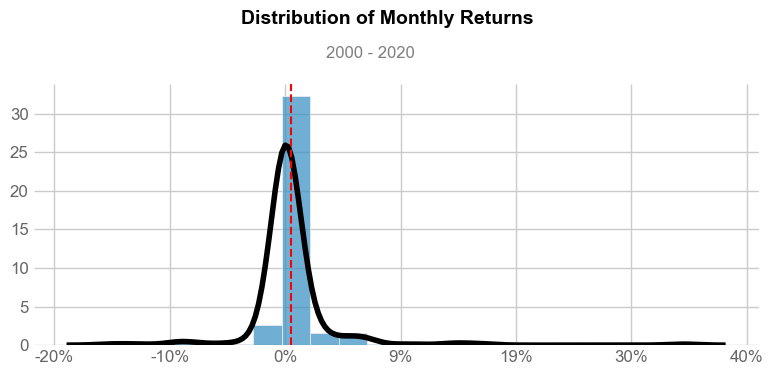

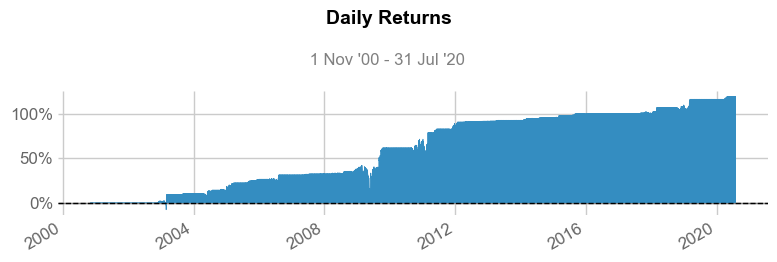

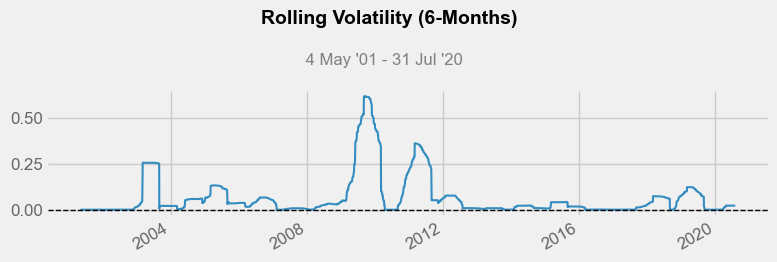

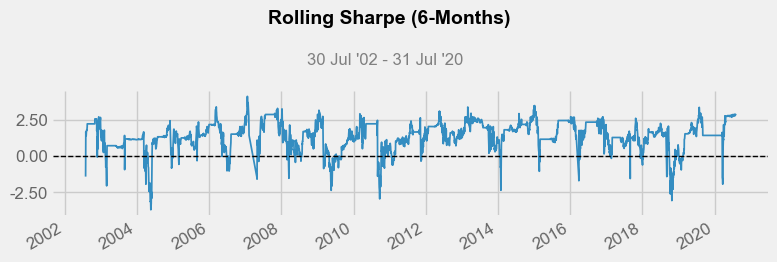

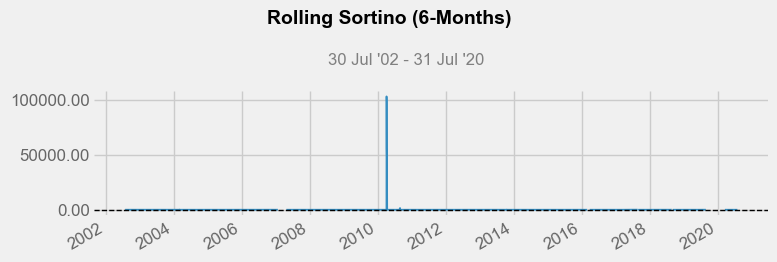

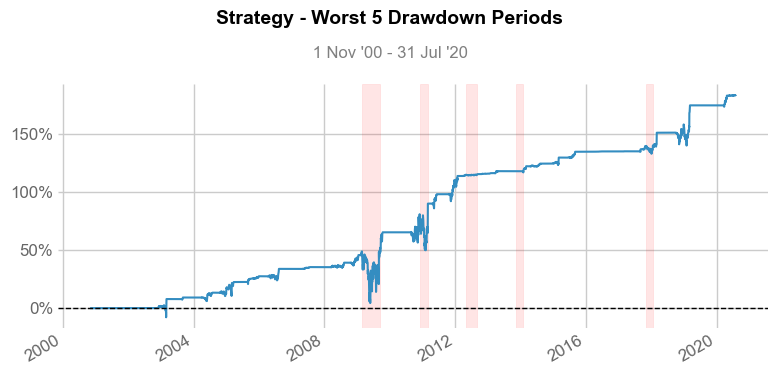

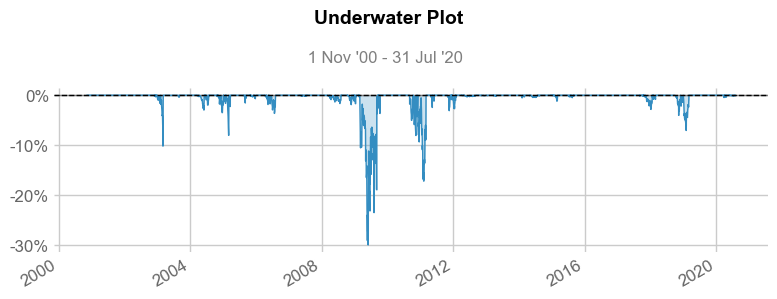

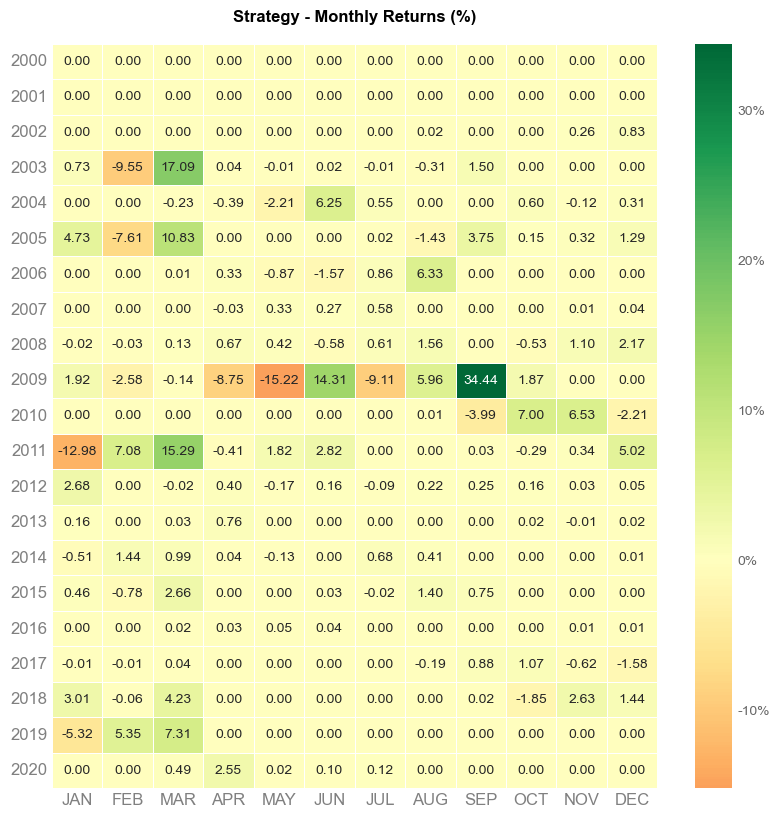

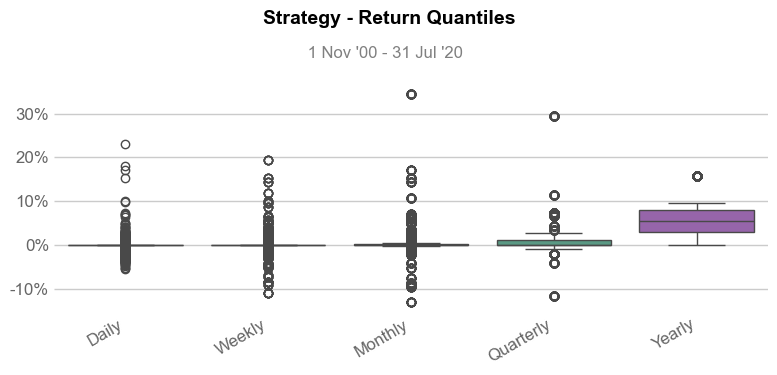

In [326]:
#qs.reports.html(returns)
qs.reports.full(train_returns)

# Backtesting

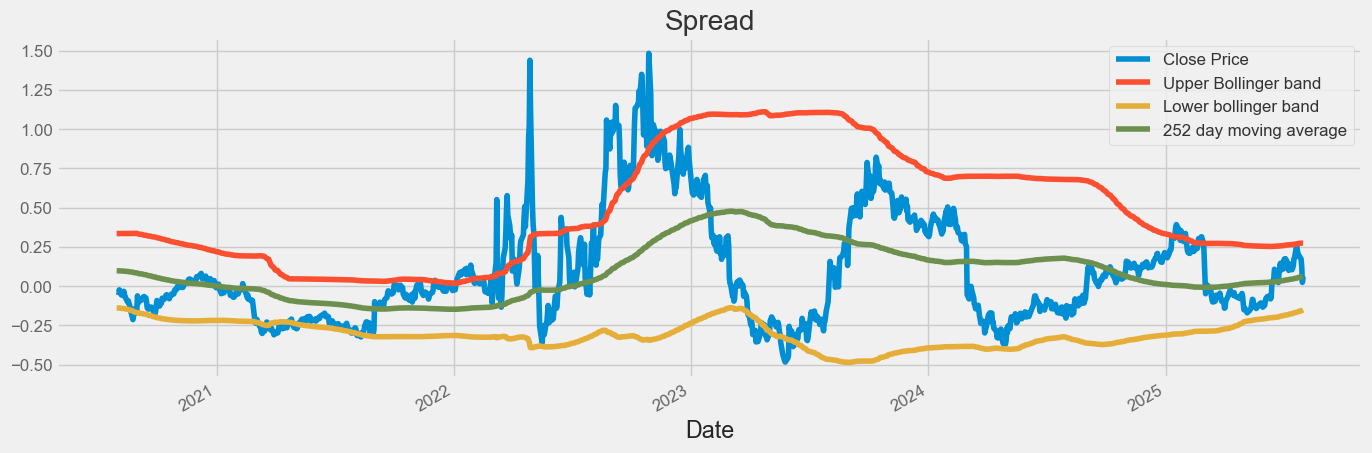

In [329]:
fig, ax = plt.subplots(figsize=(15,5))
df_test.spread.plot(ax=ax, label='Close Price', title='Spread')
df_test.spread_ub.plot(ax=ax, label='Upper Bollinger band')
df_test.spread_lb.plot(ax=ax, label='Lower bollinger band')
df_test.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

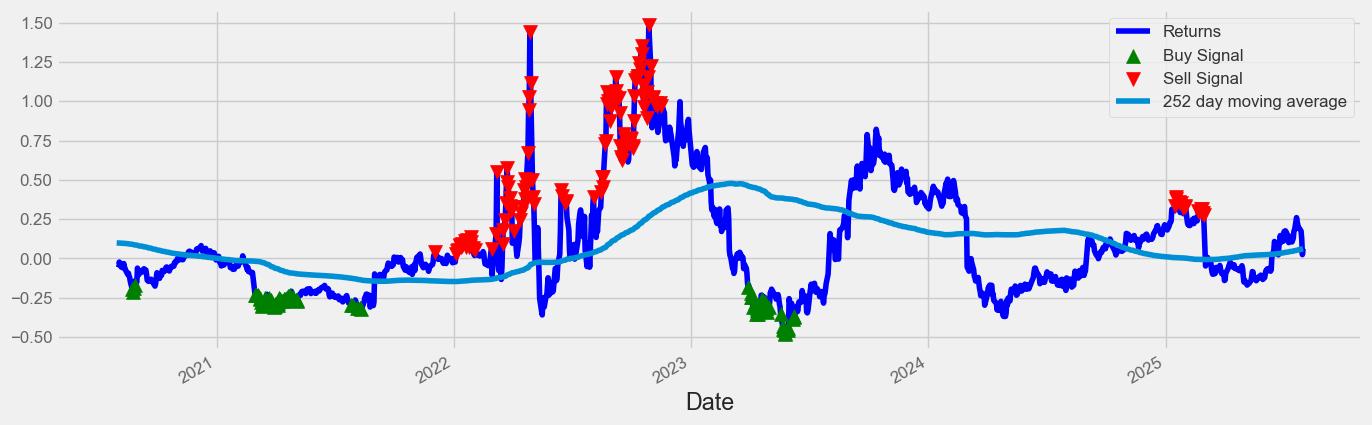

In [331]:
buy_mask = df_test.buy_signal > 0
sell_mask = df_test.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_test.index, df_test['spread'], label='Returns', color='blue')
ax.scatter(df_test.index[buy_mask], df_test['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df_test.index[sell_mask], df_test['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df_test.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [333]:
test_trader = TradingEngine(balance=1000)

In [335]:
test_returns = test_trader.run_strategy(np.array(df_test.buy_signal), np.array(df_test.sell_signal), np.array(df_test.spread), 
                    np.array(df_test.spread_ma), df_test.index, allow_negative_balance=False)

In [337]:
print(f'Final balance: {test_trader.balance:.2f}')
print(f'Net position: {test_trader.position}')
print(f'Number of trades: {test_trader.trade_count}')

Final balance: 1697.66
Net position: 0
Number of trades: 209


                           Strategy
-------------------------  ----------
Start Period               2020-07-31
End Period                 2025-07-31
Risk-Free Rate             0.0%
Time in Market             46.0%

Cumulative Return          69.77%
CAGR﹪                     7.58%

Sharpe                     0.62
Prob. Sharpe Ratio         93.36%
Smart Sharpe               0.56
Sortino                    1.09
Smart Sortino              0.97
Sortino/√2                 0.77
Smart Sortino/√2           0.69
Omega                      1.36

Max Drawdown               -27.84%
Max DD Date                2022-04-28
Max DD Period Start        2022-04-11
Max DD Period End          2022-05-03
Longest DD Days            76
Volatility (ann.)          20.19%
Calmar                     0.27
Skew                       4.54
Kurtosis                   90.85

Expected Daily %           0.04%
Expected Monthly %         0.87%
Expected Yearly %          9.22%
Kelly Criterion            13.9%
Risk of Ruin   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-04-11,2022-04-28,2022-05-03,23,-27.838536,-19.789498
2,2022-09-27,2022-10-28,2022-11-10,45,-18.759793,-14.378935
3,2022-03-02,2022-03-08,2022-03-10,9,-14.377403,-5.497958
4,2022-12-08,2022-12-15,2023-01-03,27,-11.170472,-8.750451
5,2022-11-14,2022-11-15,2022-11-21,8,-5.350917,-4.794664


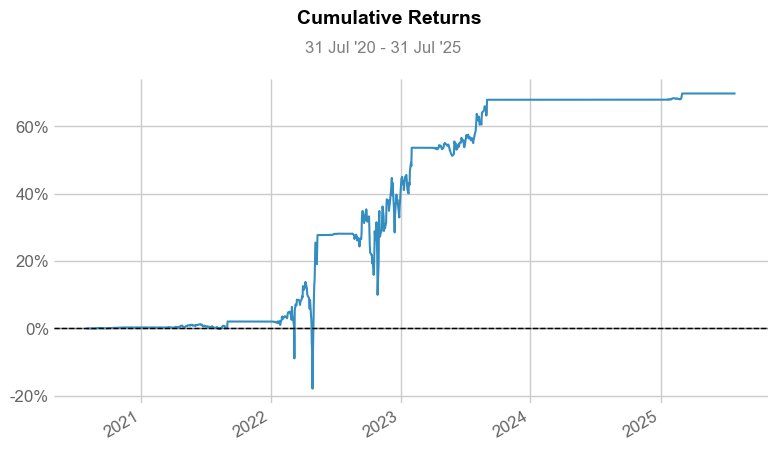

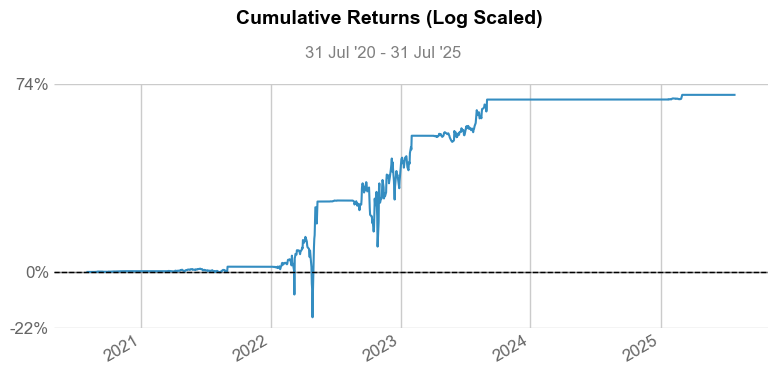

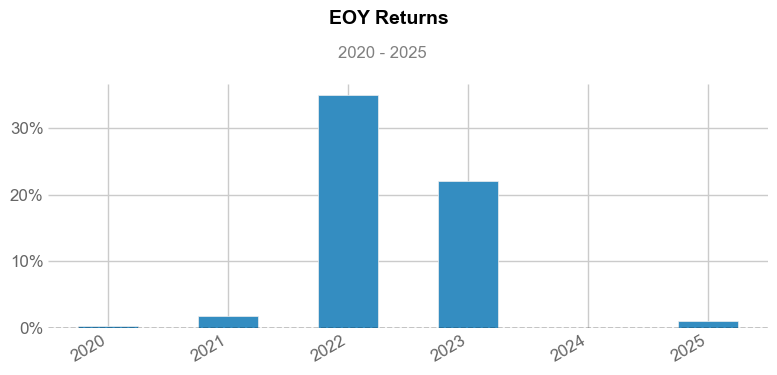

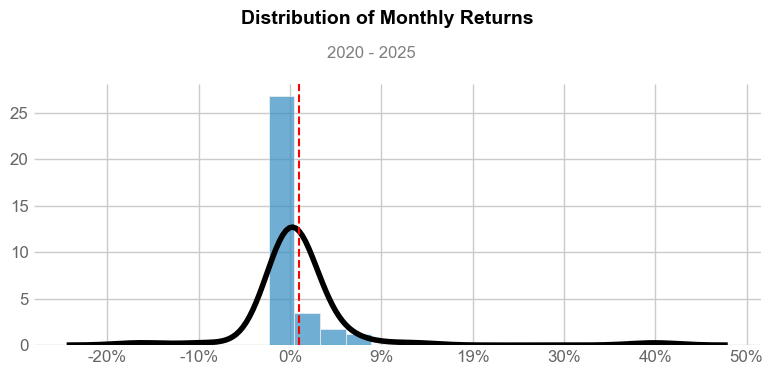

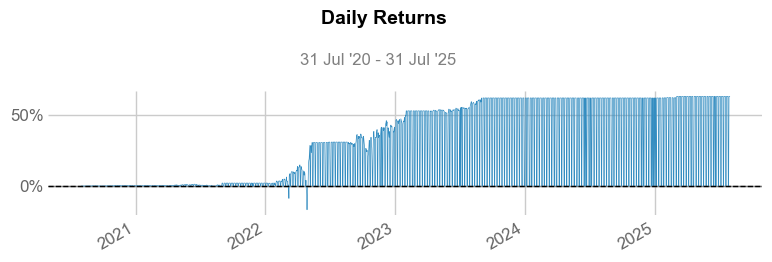

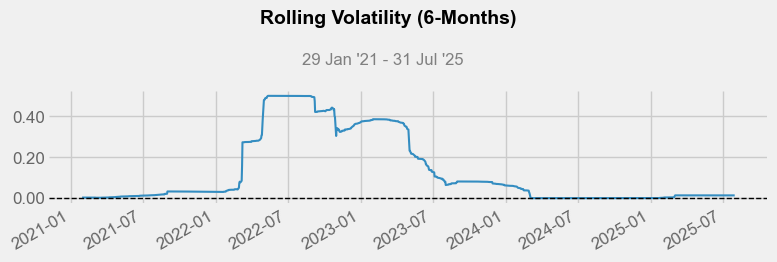

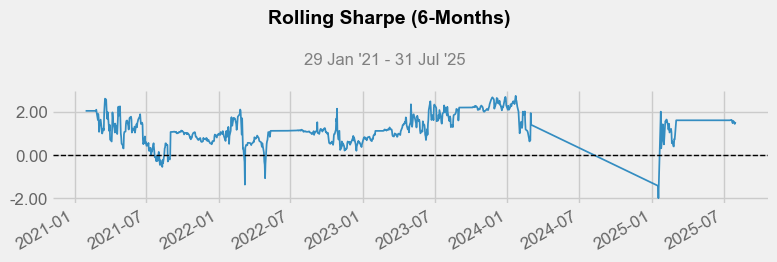

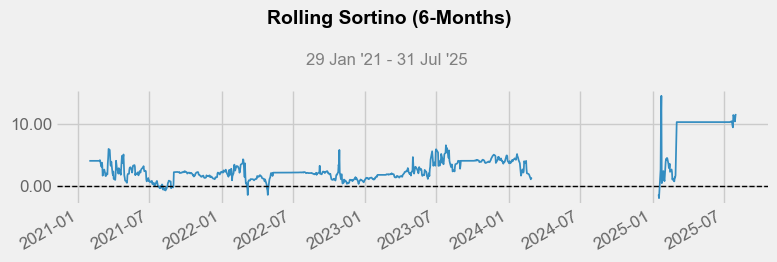

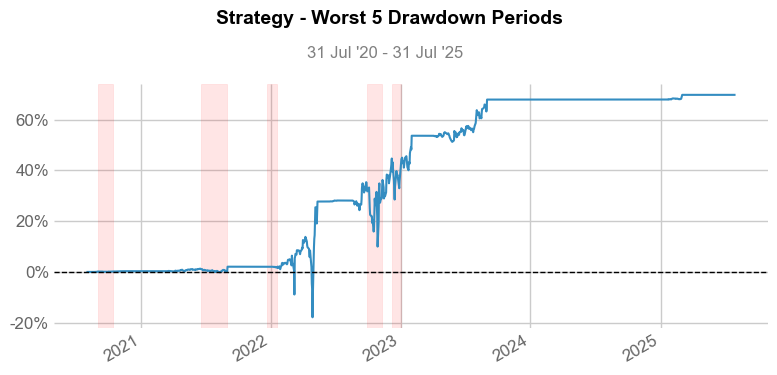

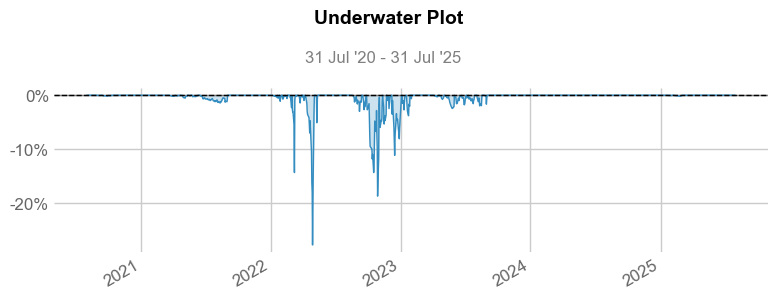

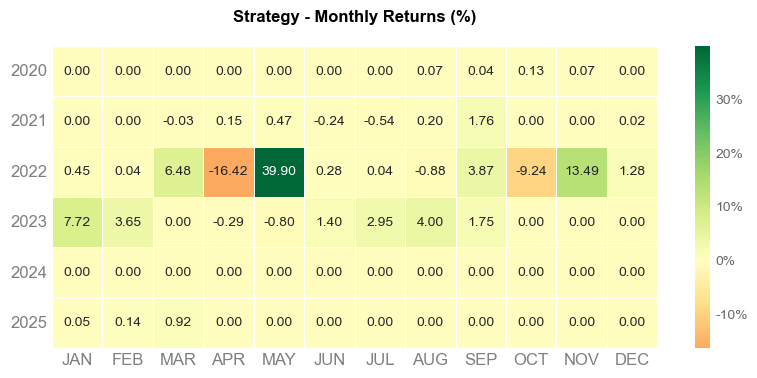

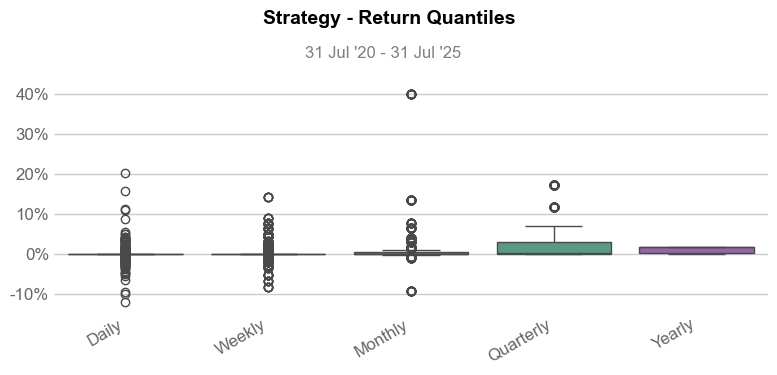

In [339]:
qs.reports.full(test_returns)